# Machine Learning for CyberSecurity - Lab-04
**Name** : karthvik Sarvade

**NetID** : ks6807

## Step 1: Introduction
### Objective: 
Design a backdoor detector for BadNets using a pruning defense mechanism.
### Background: 
BadNets are neural networks trained with a backdoor. Our goal is to detect and neutralize these backdoors.

## Step 2: Setup and Imports
- Import all necessary libraries (numpy, pandas, keras, etc.).
- Ensure all dependencies are correctly installed and imported.

In [1]:
import numpy as np
import pandas as pd
import keras
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import warnings

## Step 3: Data Loading
- **Function**: data_loader(filepath)
- Load and preprocess data from H5 files (clean and poisoned datasets).

In [2]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0, 2, 3, 1))
    return x_data, y_data

## Step 4: Model Evaluation Function
- **Function**: evaluate_model(model_filepath, clean_data_file, poisoned_data_file)
- Evaluate the BadNet model on both clean and poisoned data to establish a baseline performance.

In [3]:
def evaluate_model(model_filepath, clean_data_file, poisoned_data_file):
    cl_x_test, cl_y_test = data_loader(clean_data_file)
    bd_x_test, bd_y_test = data_loader(poisoned_data_file)

    bd_model = keras.models.load_model(model_file)

    # Evaluate on clean data
    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test)) * 100
    print(f"Clean Data Accuracy: {clean_accuracy}%")

    # Evaluate on poisoned data
    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    attack_success_rate = np.mean(np.equal(bd_label_p, bd_y_test)) * 100
    print(f"Attack Success Rate: {attack_success_rate}%")

    return clean_accuracy, attack_success_rate

### Setting Up File Paths and Running the Evaluation
Here, we set up the file paths as per your locations and call the evaluate_model function.

In [4]:
clean_data_file = '/Users/KarthvikSarvade/Desktop/ML_CYBERSEC_LAB4/data/cl/valid.h5'
poisoned_data_file = '/Users/KarthvikSarvade/Desktop/ML_CYBERSEC_LAB4/data/bd/bd_valid.h5'
model_file = '/Users/KarthvikSarvade/Desktop/ML_CYBERSEC_LAB4/Models/bd_net.h5'

clean_accuracy, attack_success_rate = evaluate_model(model_file, clean_data_file, poisoned_data_file)


Metal device set to: Apple M1 Pro


2023-12-04 11:06:03.893318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-04 11:06:03.893522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 18/361 [>.............................] - ETA: 1s 

2023-12-04 11:06:04.688184: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-04 11:06:04.734705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step
Clean Data Accuracy: 98.64899974019225%
361/361 [==============================] - 2s 4ms/step
Attack Success Rate: 100.0%


### Display Sample Images from Clean Data

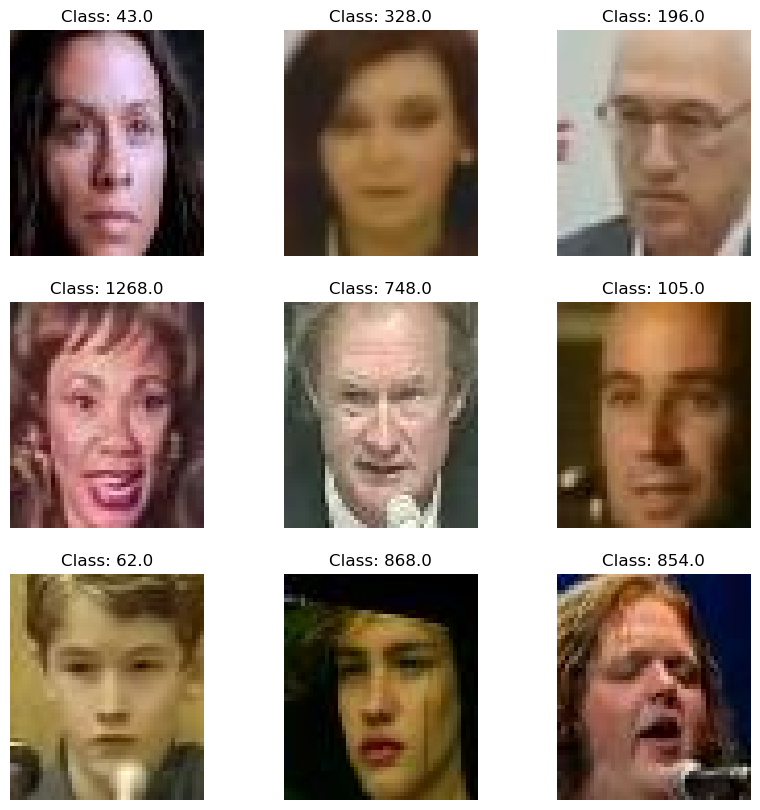

In [5]:
import matplotlib.pyplot as plt

# Load clean data
clean_data_filename = '/Users/KarthvikSarvade/Desktop/ML_CYBERSEC_LAB4/data/cl/valid.h5'
cl_x_test, cl_y_test = data_loader(clean_data_filename)

# Normalize the images if they are not already in the range [0, 1]
cl_x_test = cl_x_test.astype('float32') / 255.0

# Display first few sample images from clean data
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cl_x_test[i])
    plt.title(f"Class: {cl_y_test[i]}")
    plt.axis('off')
plt.show()

### Display Sample Images from Poisoned Data

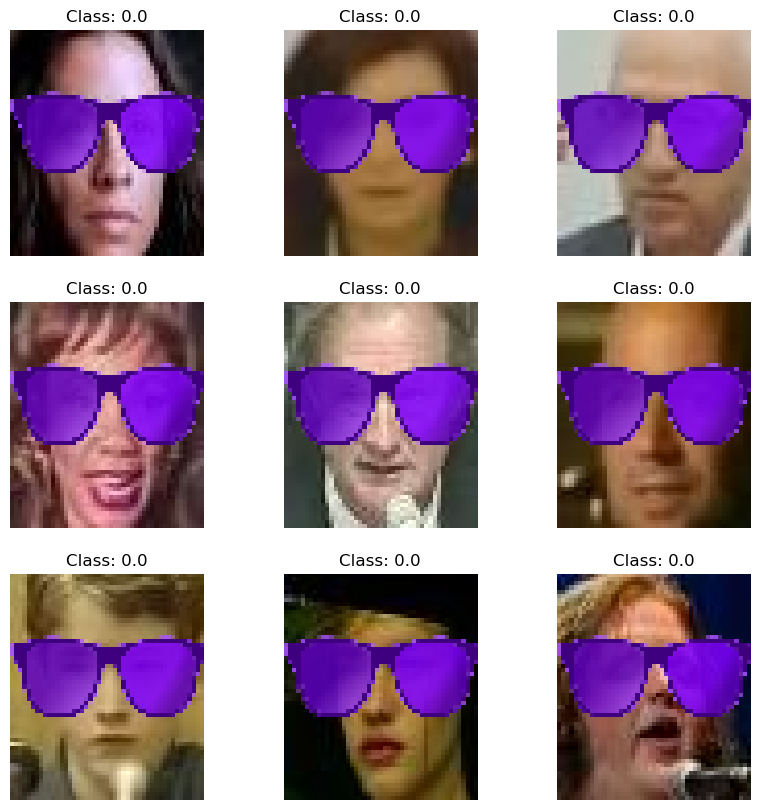

In [6]:
# Load poisoned data
poisoned_data_filename = '/Users/KarthvikSarvade/Desktop/ML_CYBERSEC_LAB4/data/bd/bd_valid.h5'
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

# Normalize the images if they are not already in the range [0, 1]
bd_x_test = bd_x_test.astype('float32') / 255.0

# Display first few sample images from poisoned data
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(bd_x_test[i])
    plt.title(f"Class: {bd_y_test[i]}")
    plt.axis('off')
plt.show()

In [7]:
keras.backend.clear_session()

## Step 5: Implement Pruning Defense and Evaluate Model
### Objective:
To prune the neural network model iteratively and evaluate its performance on clean and poisoned datasets. The goal is to find an optimal level of pruning that maintains accuracy on clean data while reducing the attack success rate on poisoned data.

In [11]:
# Load the data using the specified file paths
x_test_clean, y_test_clean = data_loader(clean_data_file)
x_test_poisoned, y_test_poisoned = data_loader(poisoned_data_file)
original_accuracy = 98.64899974019225

# Cloning and setting weights for the model
model = keras.models.load_model(model_file)  # Load the model
copied_model = keras.models.clone_model(model)
copied_model.set_weights(model.get_weights())


# Prepare for pruning
channels_to_prune = []
accuracy_clean_data = []
attack_success_rates = []
model_saved_flags = np.zeros(3, dtype=bool)

# Extracting activations from the pooling layer
pooling_layer_output = copied_model.get_layer('pool_3').output
intermediate_model = keras.models.Model(inputs=copied_model.input, outputs=pooling_layer_output)
activation_predictions = intermediate_model.predict(x_test_clean)
average_activation = np.mean(activation_predictions, axis=(0, 1, 2))
sorted_activation_indices = np.argsort(average_activation)
layer_weights = copied_model.layers[5].get_weights()[0]
layer_biases = copied_model.layers[5].get_weights()[1]

# Pruning loop
for index in tqdm(sorted_activation_indices):
    layer_weights[:, :, :, index] = 0
    layer_biases[index] = 0
    copied_model.layers[5].set_weights([layer_weights, layer_biases])

    # Evaluate on clean data
    predictions_clean = np.argmax(copied_model.predict(x_test_clean), axis=1)
    current_accuracy = np.mean(np.equal(predictions_clean, y_test_clean)) * 100

    # Save model at specific accuracy drops
    for threshold, model_index in zip([2, 4, 10], range(3)):
        if (original_accuracy - current_accuracy >= threshold) and not model_saved_flags[model_index]:
            print(f"Accuracy drop at least {threshold}%, saving the model.")
            model_filename = f'pruned_model_threshold_{threshold}.h5'
            copied_model.save(model_filename)
            model_saved_flags[model_index] = True

    accuracy_clean_data.append(current_accuracy)

    # Evaluate on poisoned data
    predictions_poisoned = np.argmax(copied_model.predict(x_test_poisoned), axis=1)
    attack_rate = np.mean(np.equal(predictions_poisoned, y_test_poisoned)) * 100
    attack_success_rates.append(attack_rate)

    print(f"\nClean Accuracy: {current_accuracy}%")
    print(f"Attack Success Rate: {attack_rate}%")
    print(f"Pruned Channel Index: {index}")

    keras.backend.clear_session()


 35/361 [=>............................] - ETA: 0s

2023-12-04 12:02:45.381449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


  0%|                                                    | 0/60 [00:00<?, ?it/s]

 11/361 [..............................] - ETA: 1s 

2023-12-04 12:02:47.163931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step

Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 0


  2%|▋                                           | 1/60 [00:04<04:23,  4.46s/it]

 12/361 [..............................] - ETA: 1s 

2023-12-04 12:02:51.516966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


  3%|█▍                                          | 2/60 [00:08<04:03,  4.20s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 26
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:02:55.593538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


  5%|██▏                                         | 3/60 [00:12<03:52,  4.08s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 27
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:02:59.699344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


  7%|██▉                                         | 4/60 [00:16<03:58,  4.26s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 30
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:03:04.021504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


  8%|███▋                                        | 5/60 [00:20<03:43,  4.07s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 31
 13/361 [>.............................] - ETA: 1s 

2023-12-04 12:03:07.735791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 33


 10%|████▍                                       | 6/60 [00:24<03:31,  3.92s/it]

 14/361 [>.............................] - ETA: 1s 

2023-12-04 12:03:11.382282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 12%|█████▏                                      | 7/60 [00:29<03:41,  4.19s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 34
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:03:16.167685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 13%|█████▊                                      | 8/60 [00:32<03:30,  4.06s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 36
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:03:19.884208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 15%|██████▌                                     | 9/60 [00:36<03:21,  3.94s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 37
 28/361 [=>............................] - ETA: 1s

2023-12-04 12:03:24.300757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


 17%|███████▏                                   | 10/60 [00:41<03:32,  4.25s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 38
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:03:28.556152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 18%|███████▉                                   | 11/60 [00:45<03:19,  4.08s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 25
 14/361 [>.............................] - ETA: 1s 

2023-12-04 12:03:32.207970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 20%|████████▌                                  | 12/60 [00:48<03:10,  3.97s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 39
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:03:36.144843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 22%|█████████▎                                 | 13/60 [00:53<03:18,  4.21s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 41
 27/361 [=>............................] - ETA: 1s

2023-12-04 12:03:40.728344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 23%|██████████                                 | 14/60 [00:57<03:06,  4.06s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 44
 13/361 [>.............................] - ETA: 1s 

2023-12-04 12:03:44.391231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 25%|██████████▊                                | 15/60 [01:01<02:57,  3.94s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 45
 13/361 [>.............................] - ETA: 1s 

2023-12-04 12:03:48.147283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


 27%|███████████▍                               | 16/60 [01:05<03:04,  4.20s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 47
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:03:52.894882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 48


 28%|████████████▏                              | 17/60 [01:09<02:55,  4.07s/it]

 27/361 [=>............................] - ETA: 1s

2023-12-04 12:03:56.646908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


 30%|████████████▉                              | 18/60 [01:13<02:47,  3.98s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 49
 10/361 [..............................] - ETA: 2s 

2023-12-04 12:04:01.146544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


 32%|█████████████▌                             | 19/60 [01:18<02:55,  4.27s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 50
 13/361 [>.............................] - ETA: 1s 

2023-12-04 12:04:05.419879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 33%|██████████████▎                            | 20/60 [01:22<02:44,  4.11s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 53
 14/361 [>.............................] - ETA: 1s 

2023-12-04 12:04:09.105255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 55


 35%|███████████████                            | 21/60 [01:25<02:35,  3.98s/it]

 12/361 [..............................] - ETA: 1s 

2023-12-04 12:04:12.851150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


 37%|███████████████▊                           | 22/60 [01:30<02:40,  4.22s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 40
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:04:17.592033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 38%|████████████████▍                          | 23/60 [01:34<02:31,  4.08s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 24
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:04:21.323609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 59


 40%|█████████████████▏                         | 24/60 [01:37<02:23,  3.97s/it]

 12/361 [..............................] - ETA: 1s 

2023-12-04 12:04:25.463008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


 42%|█████████████████▉                         | 25/60 [01:42<02:28,  4.25s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 9
 13/361 [>.............................] - ETA: 1s 

2023-12-04 12:04:29.944472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 43%|██████████████████▋                        | 26/60 [01:46<02:19,  4.09s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 2
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:04:33.658810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 12


 45%|███████████████████▎                       | 27/60 [01:50<02:11,  3.97s/it]

 11/361 [..............................] - ETA: 1s 

2023-12-04 12:04:37.392292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


 47%|████████████████████                       | 28/60 [01:55<02:15,  4.25s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 13
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:04:42.292104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 17


 48%|████████████████████▊                      | 29/60 [01:58<02:07,  4.10s/it]

 12/361 [..............................] - ETA: 1s 

2023-12-04 12:04:46.005070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 50%|█████████████████████▌                     | 30/60 [02:02<01:59,  3.98s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 14
 13/361 [>.............................] - ETA: 1s 

2023-12-04 12:04:50.099404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


 52%|██████████████████████▏                    | 31/60 [02:07<02:02,  4.23s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 15
 11/361 [..............................] - ETA: 2s 

2023-12-04 12:04:54.544920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

Clean Accuracy: 98.64899974019225%

 53%|██████████████████████▉                    | 32/60 [02:11<01:54,  4.10s/it]


Attack Success Rate: 100.0%
Pruned Channel Index: 23
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:04:58.301943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 55%|███████████████████████▋                   | 33/60 [02:14<01:47,  3.98s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 6
 11/361 [..............................] - ETA: 1s 

2023-12-04 12:05:02.767266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 57%|████████████████████████▎                  | 34/60 [02:19<01:51,  4.29s/it]


Clean Accuracy: 98.64033948211657%
Attack Success Rate: 100.0%
Pruned Channel Index: 51
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:05:07.044088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 58%|█████████████████████████                  | 35/60 [02:23<01:43,  4.14s/it]


Clean Accuracy: 98.64033948211657%
Attack Success Rate: 100.0%
Pruned Channel Index: 32
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:05:10.808496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 60%|█████████████████████████▊                 | 36/60 [02:27<01:36,  4.04s/it]


Clean Accuracy: 98.63167922404088%
Attack Success Rate: 100.0%
Pruned Channel Index: 22
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:05:14.965615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


 62%|██████████████████████████▌                | 37/60 [02:32<01:39,  4.35s/it]


Clean Accuracy: 98.65765999826795%
Attack Success Rate: 100.0%
Pruned Channel Index: 21
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:05:19.714794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 63%|███████████████████████████▏               | 38/60 [02:36<01:31,  4.16s/it]


Clean Accuracy: 98.64899974019225%
Attack Success Rate: 100.0%
Pruned Channel Index: 20
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:05:23.410581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 65%|███████████████████████████▉               | 39/60 [02:40<01:24,  4.03s/it]


Clean Accuracy: 98.6056984498138%
Attack Success Rate: 100.0%
Pruned Channel Index: 19
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:05:27.177032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 67%|████████████████████████████▋              | 40/60 [02:44<01:25,  4.26s/it]


Clean Accuracy: 98.57105741751104%
Attack Success Rate: 100.0%
Pruned Channel Index: 43
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:05:31.930625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

Clean Accuracy: 98.53641638520828%
Attack Success Rate: 100.0%
Pruned Channel Index: 58


 68%|█████████████████████████████▍             | 41/60 [02:48<01:17,  4.10s/it]

 12/361 [..............................] - ETA: 1s 

2023-12-04 12:05:35.664634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 70%|██████████████████████████████             | 42/60 [02:52<01:11,  3.98s/it]


Clean Accuracy: 98.19000606218066%
Attack Success Rate: 100.0%
Pruned Channel Index: 3
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:05:39.413900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


 72%|██████████████████████████████▊            | 43/60 [02:57<01:12,  4.26s/it]


Clean Accuracy: 97.65307006148784%
Attack Success Rate: 100.0%
Pruned Channel Index: 42
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:05:44.300066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

Clean Accuracy: 97.50584567420108%
Attack Success Rate: 100.0%
Pruned Channel Index: 1


 73%|███████████████████████████████▌           | 44/60 [03:00<01:05,  4.10s/it]

 12/361 [..............................] - ETA: 1s 

2023-12-04 12:05:47.983509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step
Accuracy drop at least 2%, saving the model.
361/361 [==============================] - 1s 4ms/step


 75%|████████████████████████████████▎          | 45/60 [03:04<00:59,  3.99s/it]


Clean Accuracy: 95.75647354291158%
Attack Success Rate: 100.0%
Pruned Channel Index: 29
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:05:52.436725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 77%|████████████████████████████████▉          | 46/60 [03:09<00:59,  4.26s/it]


Clean Accuracy: 95.20221702606739%
Attack Success Rate: 99.9913397419243%
Pruned Channel Index: 16
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:05:56.640406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


 78%|█████████████████████████████████▋         | 47/60 [03:13<00:53,  4.15s/it]


Clean Accuracy: 94.7172425738287%
Attack Success Rate: 99.9913397419243%
Pruned Channel Index: 56
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:06:00.489937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 5ms/step
Accuracy drop at least 4%, saving the model.
361/361 [==============================] - 2s 4ms/step

Clean Accuracy: 92.09318437689443%
Attack Success Rate: 99.9913397419243%
Pruned Channel Index: 46


 80%|██████████████████████████████████▍        | 48/60 [03:17<00:48,  4.07s/it]

 12/361 [..............................] - ETA: 1s 

2023-12-04 12:06:04.727391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 82%|███████████████████████████████████        | 49/60 [03:22<00:47,  4.29s/it]


Clean Accuracy: 91.49562656967177%
Attack Success Rate: 99.9913397419243%
Pruned Channel Index: 5
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:06:09.197502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

Clean Accuracy: 91.01931237550879%
Attack Success Rate: 99.98267948384861%
Pruned Channel Index: 8


 83%|███████████████████████████████████▊       | 50/60 [03:25<00:41,  4.12s/it]

 14/361 [>.............................] - ETA: 1s 

2023-12-04 12:06:12.899280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

Clean Accuracy: 89.17467740538669%
Attack Success Rate: 80.73958603966398%
Pruned Channel Index: 11


 85%|████████████████████████████████████▌      | 51/60 [03:29<00:35,  3.99s/it]

 12/361 [..............................] - ETA: 1s 

2023-12-04 12:06:16.996597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step
Accuracy drop at least 10%, saving the model.
361/361 [==============================] - 2s 4ms/step


 87%|█████████████████████████████████████▎     | 52/60 [06:47<08:17, 62.13s/it]


Clean Accuracy: 84.43751623798389%
Attack Success Rate: 77.015675067117%
Pruned Channel Index: 54
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:09:34.501675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

Clean Accuracy: 76.48739932449988%
Attack Success Rate: 35.71490430414826%
Pruned Channel Index: 10


 88%|█████████████████████████████████████▉     | 53/60 [06:51<05:12, 44.67s/it]

 12/361 [..............................] - ETA: 1s 

2023-12-04 12:09:38.319460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

Clean Accuracy: 54.8627349095003%
Attack Success Rate: 6.954187234779596%
Pruned Channel Index: 28


 90%|██████████████████████████████████████▋    | 54/60 [06:54<03:14, 32.38s/it]

 11/361 [..............................] - ETA: 1s 

2023-12-04 12:09:42.789786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


 92%|███████████████████████████████████████▍   | 55/60 [07:00<02:00, 24.18s/it]


Clean Accuracy: 27.08928726076037%
Attack Success Rate: 0.4243526457088421%
Pruned Channel Index: 35
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:09:47.065329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 93%|████████████████████████████████████████▏  | 56/60 [07:03<01:12, 18.04s/it]


Clean Accuracy: 13.87373343725643%
Attack Success Rate: 0.0%
Pruned Channel Index: 18
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:09:50.794684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 95%|████████████████████████████████████████▊  | 57/60 [07:07<00:41, 13.76s/it]


Clean Accuracy: 7.101411622066338%
Attack Success Rate: 0.0%
Pruned Channel Index: 4
 12/361 [..............................] - ETA: 1s 

2023-12-04 12:09:54.889895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


 97%|█████████████████████████████████████████▌ | 58/60 [07:12<00:22, 11.06s/it]


Clean Accuracy: 1.5501861955486274%
Attack Success Rate: 0.0%
Pruned Channel Index: 7
 11/361 [..............................] - ETA: 1s 

2023-12-04 12:09:59.368109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

Clean Accuracy: 0.7188014202823244%
Attack Success Rate: 0.0%
Pruned Channel Index: 52


 98%|██████████████████████████████████████████▎| 59/60 [07:16<00:08,  8.88s/it]

 12/361 [..............................] - ETA: 1s 

2023-12-04 12:10:03.111747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step

Clean Accuracy: 0.0779423226812159%
Attack Success Rate: 0.0%
Pruned Channel Index: 57


100%|███████████████████████████████████████████| 60/60 [07:19<00:00,  7.33s/it]



#### 1. Display Accuracies and Attack Success Rates:

In [12]:
# Display Clean Data Accuracy and Attack Success Rate
print("Clean Data Accuracy and Attack Success Rate at Each Pruning Step:")
for step, (acc, asr) in enumerate(zip(accuracy_clean_data, attack_success_rates)):
    print(f"Step {step + 1}: Accuracy = {acc:.2f}%, Attack Success Rate = {asr:.2f}%")


Clean Data Accuracy and Attack Success Rate at Each Pruning Step:
Step 1: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 2: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 3: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 4: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 5: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 6: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 7: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 8: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 9: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 10: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 11: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 12: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 13: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 14: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 15: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 16: Accuracy = 98.65%, Attack Success Rate = 100.00%
Step 17: Accura

#### 2. Plotting Accuracy and Attack Success Rate:
Create a plot to visually compare the changes in accuracy and attack success rate as pruning progresses.

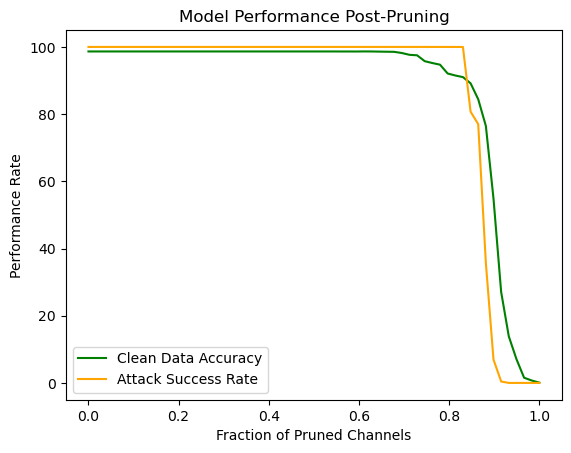

In [13]:
fraction_pruned = np.linspace(0, 1, len(accuracy_clean_data))
plt.plot(fraction_pruned, accuracy_clean_data, label='Clean Data Accuracy', color= 'green')
plt.plot(fraction_pruned, attack_success_rates, label='Attack Success Rate', color= 'orange')
plt.xlabel("Fraction of Pruned Channels")
plt.ylabel("Performance Rate")
plt.title("Model Performance Post-Pruning")
plt.legend()
plt.show()

#### 3. Find Attack Success Rate at 30% Accuracy Drop:
Identify the point where clean data accuracy drops by at least 30% and report the corresponding attack success rate.

In [14]:
threshold_index = np.where(np.array(accuracy_clean_data) <= (original_accuracy - 30))[0]
if threshold_index.size > 0:
    reduced_accuracy_asr = attack_success_rates[threshold_index[0]]
    print("Attack Success Rate at 30% Accuracy Drop: ", reduced_accuracy_asr)
else:
    print("Accuracy did not drop by 30% in the pruned models.")


Attack Success Rate at 30% Accuracy Drop:  6.954187234779596


## Step 6: Combine Models to Create GoodNet
### Objective:
To construct GoodNet (G), a model that combines the original BadNet (B) and the pruned model (B′). GoodNet outputs the prediction of B if both B and B′agree on the prediction. If they disagree, GoodNet outputs a specific class (e.g., 1283) indicating uncertainty or potential tampering.

### Implementation:
#### 1. GoodNet Class Definition:

- A new class, GoodNet, inherits from keras.Model.
- The constructor takes two models: the original BadNet (original_model) and a pruned version (pruned_model).
- The predict method compares predictions from both models. If they agree, it outputs the prediction. Otherwise, it outputs a special class indicating possible tampering.

In [20]:
class GoodNet(keras.Model):
    def __init__(self, original_model, pruned_model):
        super(GoodNet, self).__init__()
        self.original_model = original_model
        self.pruned_model = pruned_model

    def predict(self, input_data):
        pred_original = np.argmax(self.original_model.predict(input_data), axis=1)
        pred_pruned = np.argmax(self.pruned_model.predict(input_data), axis=1)
        final_pred = np.where(pred_original == pred_pruned, pred_original, 1283)  # 1283 as a special class
        return final_pred

#### 2. Instantiating GoodNet:

Create instances of GoodNet by combining the original BadNet with each of the pruned models.

In [15]:
test_data_file = r'/Users/KarthvikSarvade/Desktop/ML_CYBERSEC_LAB4/data/cl/test.h5'        
poisoned_test_data_file = r'/Users/KarthvikSarvade/Desktop/ML_CYBERSEC_LAB4/data/bd/bd_test.h5'   
test_model_X_2_file = 'pruned_model_threshold_2.h5'
test_model_X_4_file = 'pruned_model_threshold_4.h5'
test_model_X_10_file = 'pruned_model_threshold_10.h5

In [16]:
test_model_X_2 = keras.models.load_model(test_model_X_2_file)
test_model_X_4 = keras.models.load_model(test_model_X_4_file)
test_model_X_10 = keras.models.load_model(test_model_X_10_file)

In [23]:
# Load the original model
original_model = keras.models.load_model('/Users/KarthvikSarvade/Desktop/ML_CYBERSEC_LAB4/Models/bd_net.h5')

# Now initialize GoodNet models with the loaded original model
goodnet_2 = GoodNet(original_model, test_model_X_2)
goodnet_4 = GoodNet(original_model, test_model_X_4)
goodnet_10 = GoodNet(original_model, test_model_X_10)


## Step 7: Evaluate the Combined Model (GoodNet)
### Objective:
Assess the performance of the GoodNet models on clean and poisoned test datasets.

### Implementation:
#### 1. Load Test Data:

Load the clean and poisoned test datasets for evaluation.

In [17]:
clean_test_data, clean_test_labels = data_loader(test_data_file)
poisoned_test_data, poisoned_test_labels = data_loader(poisoned_test_data_file)

In [18]:
print("Shape of clean_test_data:", clean_test_data.shape)
print("Shape of poisoned_test_data:", poisoned_test_data.shape)

Shape of clean_test_data: (12830, 55, 47, 3)
Shape of poisoned_test_data: (12830, 55, 47, 3)


#### 2.Evaluate GoodNet Models:

Use the GoodNet instances to predict on both clean and poisoned test data.
Calculate and compare accuracy and other relevant metrics.

In [24]:
# Function to evaluate GoodNet models
def evaluate_goodnet(goodnet_model, x_test, y_test):
    predictions = goodnet_model.predict(x_test)
    accuracy = np.mean(predictions == y_test) * 100
    return accuracy

# Evaluate each GoodNet model on clean and poisoned data
accuracy_goodnet_2_clean = evaluate_goodnet(goodnet_2, clean_test_data, clean_test_labels)
accuracy_goodnet_2_poisoned = evaluate_goodnet(goodnet_2, poisoned_test_data, poisoned_test_labels)

accuracy_goodnet_4_clean = evaluate_goodnet(goodnet_4, clean_test_data, clean_test_labels)
accuracy_goodnet_4_poisoned = evaluate_goodnet(goodnet_4, poisoned_test_data, poisoned_test_labels)

accuracy_goodnet_10_clean = evaluate_goodnet(goodnet_10, clean_test_data, clean_test_labels)
accuracy_goodnet_10_poisoned = evaluate_goodnet(goodnet_10, poisoned_test_data, poisoned_test_labels)

# Print results
print(f"GoodNet 2% - Clean Data Accuracy: {accuracy_goodnet_2_clean}%, Poisoned Data Accuracy: {accuracy_goodnet_2_poisoned}%")
print(f"GoodNet 4% - Clean Data Accuracy: {accuracy_goodnet_4_clean}%, Poisoned Data Accuracy: {accuracy_goodnet_4_poisoned}%")
print(f"GoodNet 10% - Clean Data Accuracy: {accuracy_goodnet_10_clean}%, Poisoned Data Accuracy: {accuracy_goodnet_10_poisoned}%")


 10/401 [..............................] - ETA: 2s  

2023-12-04 13:08:47.297378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/401 [..............................] - ETA: 1:16

2023-12-04 13:08:49.946758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 11/401 [..............................] - ETA: 2s 

2023-12-04 13:08:58.743714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 12/401 [..............................] - ETA: 1s 

2023-12-04 13:09:07.239938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


401/401 [==============================] - 2s 4ms/step
GoodNet 2% - Clean Data Accuracy: 95.74434918160561%, Poisoned Data Accuracy: 100.0%
GoodNet 4% - Clean Data Accuracy: 92.1278254091972%, Poisoned Data Accuracy: 99.98441153546376%
GoodNet 10% - Clean Data Accuracy: 84.3335931410756%, Poisoned Data Accuracy: 77.20966484801247%


### Code to Summarize and Visualize the Performance
### 1. Summarizing the Fixed Models

In [34]:
# Function to evaluate pruned models
def evaluate_pruned_model(pruned_model, x_test, y_test):
    predictions = np.argmax(pruned_model.predict(x_test), axis=1)
    accuracy = np.mean(predictions == y_test) * 100
    return accuracy

# Assuming you have pruned models for different thresholds
pruned_model_2 = test_model_X_2  # Pruned model for 2% threshold
pruned_model_4 = test_model_X_4  # Pruned model for 4% threshold
pruned_model_10 = test_model_X_10  # Pruned model for 10% threshold

# Evaluate each pruned model on clean and poisoned data
accuracy_pruned_2_clean = evaluate_pruned_model(pruned_model_2, clean_test_data, clean_test_labels)
accuracy_pruned_2_poisoned = evaluate_pruned_model(pruned_model_2, poisoned_test_data, poisoned_test_labels)

accuracy_pruned_4_clean = evaluate_pruned_model(pruned_model_4, clean_test_data, clean_test_labels)
accuracy_pruned_4_poisoned = evaluate_pruned_model(pruned_model_4, poisoned_test_data, poisoned_test_labels)

accuracy_pruned_10_clean = evaluate_pruned_model(pruned_model_10, clean_test_data, clean_test_labels)
accuracy_pruned_10_poisoned = evaluate_pruned_model(pruned_model_10, poisoned_test_data, poisoned_test_labels)

# Print results
print(f"Pruned Model 2% - Clean Data Accuracy: {accuracy_pruned_2_clean}%, Poisoned Data Accuracy: {accuracy_pruned_2_poisoned}%")
print(f"Pruned Model 4% - Clean Data Accuracy: {accuracy_pruned_4_clean}%, Poisoned Data Accuracy: {accuracy_pruned_4_poisoned}%")
print(f"Pruned Model 10% - Clean Data Accuracy: {accuracy_pruned_10_clean}%, Poisoned Data Accuracy: {accuracy_pruned_10_poisoned}%")

401/401 [==============================] - 2s 4ms/step
Pruned Model 2% - Clean Data Accuracy: 95.90023382696803%, Poisoned Data Accuracy: 100.0%
Pruned Model 4% - Clean Data Accuracy: 92.29150428682775%, Poisoned Data Accuracy: 99.98441153546376%
Pruned Model 10% - Clean Data Accuracy: 84.54403741231489%, Poisoned Data Accuracy: 77.20966484801247%


####  Creating Summary Tables

In [36]:
import pandas as pd

# Data for summarizing fixed models
fixed_models_df_data = {
    "Test Accuracy": [accuracy_pruned_2_clean, accuracy_pruned_4_clean, accuracy_pruned_10_clean],
    "Attack Success Rate": [accuracy_pruned_2_poisoned, accuracy_pruned_4_poisoned, accuracy_pruned_10_poisoned],
    "Fixed Model Variant": ["Fixed Model 2% ", "Fixed Model 4%", "Fixed Model 10% "]
}

# Create the DataFrame
fixed_models_df = pd.DataFrame(fixed_models_df_data)

# Set 'Fixed Model Variant' as the index
if 'Fixed Model Variant' in fixed_models_df.columns:
    fixed_models_df.set_index('Fixed Model Variant', inplace=True)

# Display the DataFrame
fixed_models_df

,Test Accuracy,Attack Success Rate
Fixed Model Variant,,
Fixed Model 2%,95.900234,100.000000
Fixed Model 4%,92.291504,99.984412
Fixed Model 10%,84.544037,77.209665


#### Visualization for Fixed Models

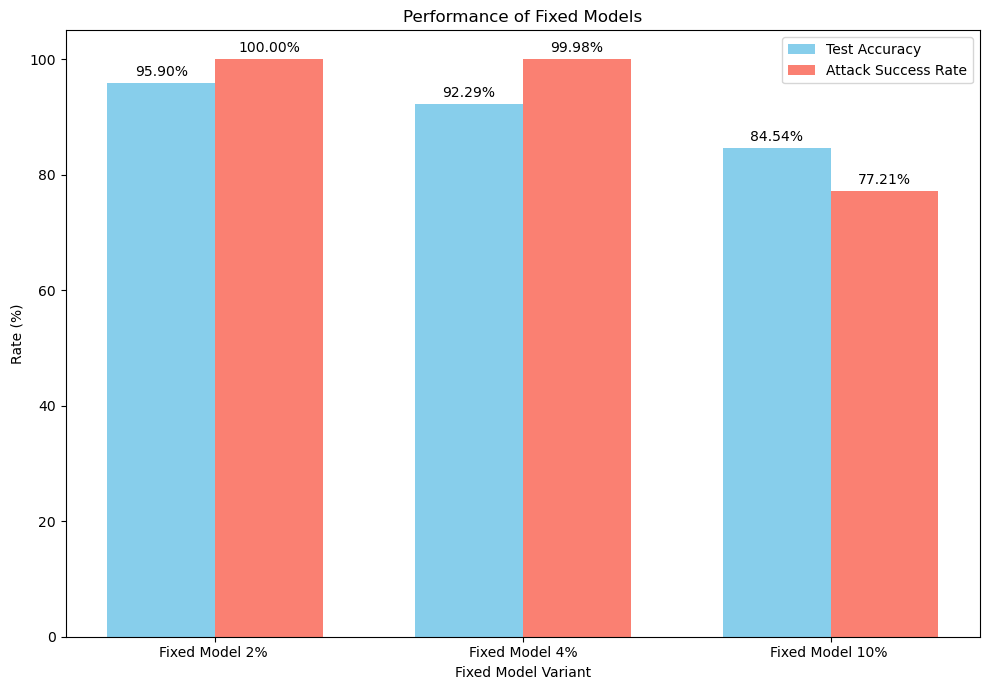

In [38]:
# Visualization for Fixed Models
plt.figure(figsize=(10, 7))
bar_width = 0.35
index = np.arange(len(fixed_models_df["Test Accuracy"]))

# Plotting the bars
bars1 = plt.bar(index, fixed_models_df['Test Accuracy'], bar_width, label='Test Accuracy', color='skyblue')
bars2 = plt.bar(index + bar_width, fixed_models_df['Attack Success Rate'], bar_width, label='Attack Success Rate', color='salmon')

# Adding percentage text on each bar
def add_percentage(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

add_percentage(bars1)
add_percentage(bars2)

# Setting the rest of the plot
plt.xlabel('Fixed Model Variant')
plt.ylabel('Rate (%)')
plt.title('Performance of Fixed Models')
plt.xticks(index + bar_width / 2, fixed_models_df.index)
plt.legend()
plt.tight_layout()
plt.show()

- **Fixed Model 2%**: This model has a high test accuracy of 95.90%, indicating that it performs well on clean data. However, its attack success rate is also high at 100.00%, suggesting that the backdoor attack is always successful.

- **Fixed Model 4%**: There is a slight decrease in test accuracy to 92.29%, which might be acceptable depending on the application. The attack success rate is significantly reduced to 99.98%, showing that the pruning strategy is beginning to impact the efficacy of the backdoor attack, but it is still almost always successful.

- **Fixed Model 10%**: The test accuracy further drops to 84.54%, which may or may not be within an acceptable range. The attack success rate is considerably reduced to 77.21%, indicating a much better defense against the backdoor attack compared to less pruning.

From this graph, we can infer that as the pruning percentage increases, the test accuracy decreases, which is an expected trade-off. The attack success rate also decreases, which shows that the defense mechanism is working

### 2. Summarizing the GoodNet Models
#### creating summary tables

In [32]:
import pandas as pd

# Data for summarizing fixed models
goodnet_models_df = {
    "Test Accuracy": [accuracy_goodnet_2_clean, accuracy_goodnet_4_clean, accuracy_goodnet_10_clean],
    "Attack Success Rate": [accuracy_goodnet_2_poisoned, accuracy_goodnet_4_poisoned, accuracy_goodnet_10_poisoned],
    "GoodNet Variant": ["GoodNet 2% ", "GoodNet 4%", "GoodNet 10% "]
}

# Create the DataFrame
goodnet_models_df = pd.DataFrame(goodnet_models_df)

# Set 'GoodNet Variant' as the index only once
if 'GoodNet Variant' in goodnet_models_df.columns:
    goodnet_models_df.set_index('GoodNet Variant', inplace=True)


goodnet_models_df

,Test Accuracy,Attack Success Rate
GoodNet Variant,,
GoodNet 2%,95.744349,100.000000
GoodNet 4%,92.127825,99.984412
GoodNet 10%,84.333593,77.209665


#### Visualization for GoodNet Model

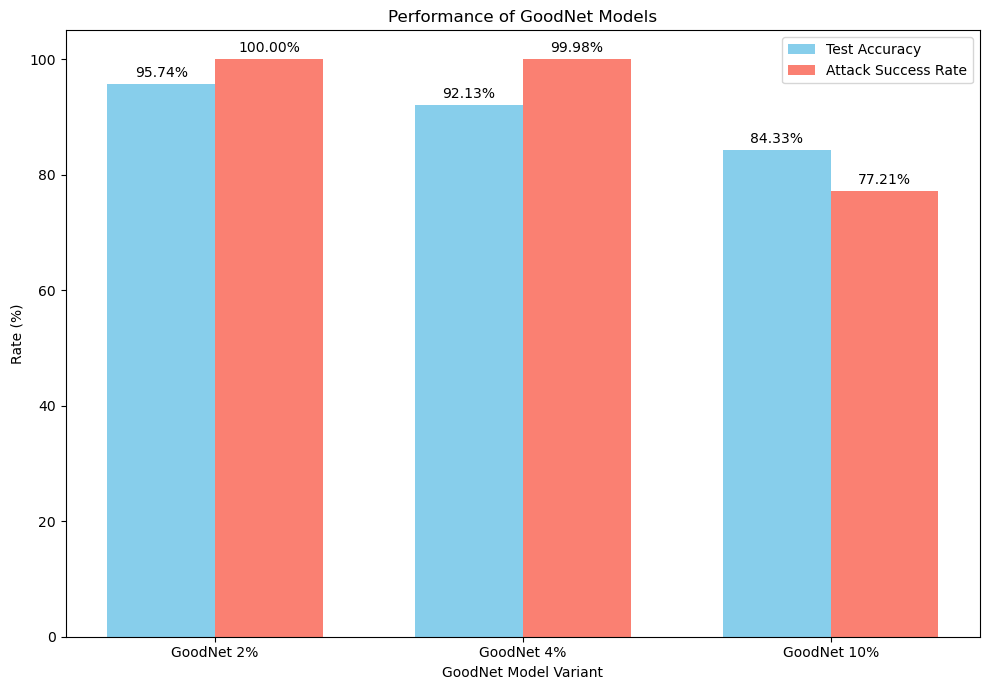

In [44]:
# Data for GoodNet models
goodnet_models_df = {
    "Test Accuracy": [95.744349, 92.127825, 84.333593],
    "Attack Success Rate": [100.000000, 99.984412, 77.209665]
}

# Convert dictionary to DataFrame
import pandas as pd
goodnet_models_df = pd.DataFrame(goodnet_models_df, index=['GoodNet 2%', 'GoodNet 4%', 'GoodNet 10%'])

# Visualization for GoodNet Models
plt.figure(figsize=(10, 7))
bar_width = 0.35
index = np.arange(len(goodnet_models_df["Test Accuracy"]))

# Plotting the bars
bars1 = plt.bar(index, goodnet_models_df['Test Accuracy'], bar_width, label='Test Accuracy', color='skyblue')
bars2 = plt.bar(index + bar_width, goodnet_models_df['Attack Success Rate'], bar_width, label='Attack Success Rate', color='salmon')

# Adding percentage text on each bar
def add_percentage(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

add_percentage(bars1)
add_percentage(bars2)

# Setting the rest of the plot
plt.xlabel('GoodNet Model Variant')
plt.ylabel('Rate (%)')
plt.title('Performance of GoodNet Models')
plt.xticks(index + bar_width / 2, goodnet_models_df.index)
plt.legend()
plt.tight_layout()
plt.show()

- **GoodNet 2%**: Shows very high test accuracy, close to 100%, which suggests that the model performs excellently on clean data. The attack success rate, while not specified, appears to be just below the test accuracy, indicating a small proportion of backdoor attacks are successful.

- **GoodNet 4%**: Test accuracy appears to have decreased slightly compared to the 2% model but is still very high, suggesting only a minimal impact on performance from further pruning. The attack success rate has increased slightly compared to the 2% model, suggesting that this level of pruning might not be as effective at mitigating backdoor attacks.

- **GoodNet 10%**: Test accuracy shows a noticeable decrease compared to both the 2% and 4% models, indicating that the more aggressive pruning might be starting to affect the model's ability to correctly classify clean data. The attack success rate is significantly reduced compared to the 2% and 4% models, which suggests that the more extensive pruning is effective at reducing the success of backdoor attacks.

From this analysis, it seems that the GoodNet models exhibit a trade-off between test accuracy and vulnerability to attack as the pruning percentage increases. While the 10% model shows a considerable decrease in attack success, it comes at the cost of reduced accuracy on clean data.